# Color detection

In [417]:
# Imports
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

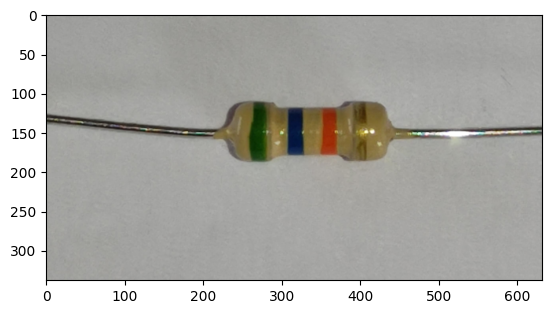

In [418]:
# Load image
images_path_names = glob.glob('../../data/resistor_data/img_*.png')
image = cv2.imread(images_path_names[12])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

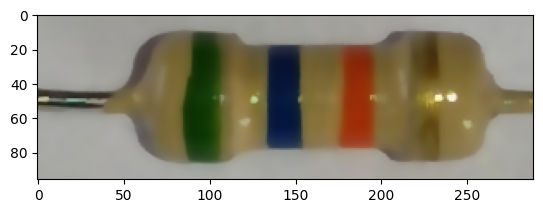

In [419]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Load resistor haar cascade classifier
rectcascade = cv2.CascadeClassifier("../../data/haar_cascade_files/haarcascade_resistors_0.xml")

# Detect resistor
resistors = rectcascade.detectMultiScale(gray)

# Create the bounding box around the detected resistor
for (x, y, w, h) in resistors:
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = image[y:y + h, x:x + w]

# Apply bilateral filter 
roi_bil = cv2.bilateralFilter(roi_color, 9,75,75)
            
# Show image of detected resistor and save it in folder 'images_code'
plt.imshow(roi_bil)

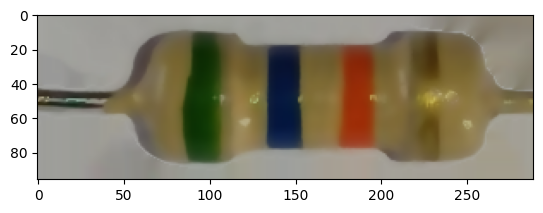

In [420]:
# To grayscale
gray = cv2.cvtColor(roi_bil, cv2.COLOR_BGR2GRAY)

# Threshold grayscale image to extract glare
mask = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)[1]

# use mask with input to do inpainting
roi_bil = cv2.inpaint(roi_bil, mask, 10, cv2.INPAINT_NS) 

# Show image of detected resistor and save it in folder 'images_code'
plt.imshow(roi_bil)

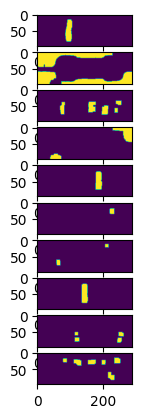

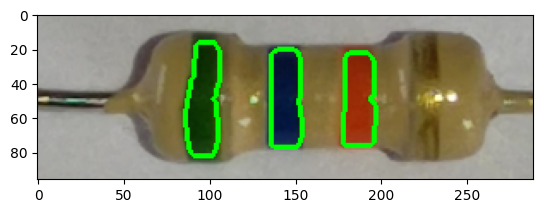

In [421]:
# Prepare data
data = roi_bil.reshape(np.shape(roi_bil)[0]*np.shape(roi_bil)[1], np.shape(roi_bil)[2])
data = np.float32(data)

# Cluster data
clt = KMeans(n_clusters = 10)
clt.fit(data)

# New image
band_data = {}
labels = np.unique(clt.labels_)
for i in labels:

    # Get image
    new_image = np.uint8(clt.labels_.reshape(np.shape(roi_bil)[0], np.shape(roi_bil)[1])==i)

    # Canny
    kernel = np.ones((10,10),np.uint8)
    new_image = cv2.morphologyEx(new_image, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, hierarchy = cv2.findContours(new_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # Loop over contours
    for cnt in contours:

        # Find area of contour
        area = cv2.contourArea(cnt)

        # Find aspect ratio of contour
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = float(w)/h

        # Find center of contour
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # Filter contours
        if aspect_ratio < 0.5 and area > 500:

            # Add band to band data
            band_data[cX] = roi_color[new_image == 1]

            # Draw contour
            cv2.drawContours(roi_color, cnt, -1, (0, 255, 0), 2)

        # Plot
        plt.subplot(len(labels), 1, i+1)
        plt.imshow(new_image)

# Plot
plt.figure(2)
plt.imshow(roi_color)
